In [1]:
%matplotlib inline

from mesa import Mesa
from utils import Rater, load_dataset
from jupyter_argparser.core import argparse
from sklearn.tree import *
from copy import deepcopy
import time


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser(description='Mesa Arguments')
parser.add_argument('--env-name', default="MESA-SAC")

# SAC arguments
parser.add_argument('--policy', default="Gaussian",
                    help='Policy Type: Gaussian | Deterministic (default: Gaussian)')
parser.add_argument('--eval', type=bool, default=True,
                    help='Evaluates a policy every 10 episode (default: True)')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor for reward (default: 0.99)')
parser.add_argument('--tau', type=float, default=0.01, metavar='G',
                    help='target smoothing coefficient(τ) (default: 0.01)')
parser.add_argument('--lr', type=float, default=0.001, metavar='G',
                    help='learning rate (default: 0.001)')
parser.add_argument('--lr_decay_steps', type=int, default=10, metavar='N',
                    help='step_size of StepLR learning rate decay scheduler (default: 10)')
parser.add_argument('--lr_decay_gamma', type=float, default=0.99, metavar='N',
                    help='gamma of StepLR learning rate decay scheduler (default: 0.99)')
parser.add_argument('--alpha', type=float, default=0.1, metavar='G',
                    help='Temperature parameter α determines the relative importance of the entropy\
                            term against the reward (default: 0.1)')
parser.add_argument('--automatic_entropy_tuning', type=bool, default=False, metavar='G',
                    help='Automaically adjust α (default: False)')
parser.add_argument('--seed', type=int, default=None, metavar='N',
                    help='random seed (default: None)')
parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                    help='batch size (default: 64)')
parser.add_argument('--hidden_size', type=int, default=50, metavar='N',
                    help='hidden size (default: 50)')
parser.add_argument('--updates_per_step', type=int, default=1, metavar='N',
                    help='model updates per simul|ator step (default: 1)')
parser.add_argument('--update_steps', type=int, default=1000, metavar='N',
                    help='maximum number of steps (default: 1000)')
parser.add_argument('--start_steps', type=int, default=500, metavar='N',
                    help='Steps sampling random actions (default: 500)')
parser.add_argument('--target_update_interval', type=int, default=1, metavar='N',
                    help='Value target update per no. of updates per step (default: 1)')
parser.add_argument('--replay_size', type=int, default=1000, metavar='N',
                    help='size of replay buffer (default: 1000)')
parser.add_argument('--cuda', action="store_true", default=False,
                    help='run on CUDA (default: False)')

# MESA arguments
parser.add_argument('--dataset', type=str, default='Mammo', metavar='N',
                    help='the dataset used for meta-training (default: Mammo)')
parser.add_argument('--metric', type=str, default='aucprc', metavar='N',
                    help='the metric used for evaluate (default: aucprc)')
parser.add_argument('--reward_coefficient', type=float, default=100, metavar='N')
parser.add_argument('--num_bins', type=int, default=5, metavar='N', 
                    help='number of bins (default: 5). state-size = 2 * num_bins.')
parser.add_argument('--sigma', type=float, default=0.2, metavar='N', 
                    help='sigma of the Gaussian function used in meta-sampling (default: 0.2)')
parser.add_argument('--max_estimators', type=int, default=10, metavar='N',
                    help='maximum number of base estimators in each meta-training episode (default: 10)')
parser.add_argument('--meta_verbose', type=int, default=10, metavar='N',
                    help='number of episodes between verbose outputs. \
                    If \'full\' print log for each base estimator (default: 10)')
parser.add_argument('--meta_verbose_mean_episodes', type=int, default=25, metavar='N',
                    help='number of episodes used for compute latest mean score in verbose outputs.')
parser.add_argument('--verbose', type=bool, default=False, metavar='N',
                    help='enable verbose when ensemble fit (default: False)')
parser.add_argument('--random_state', type=int, default=None, metavar='N', 
                    help='random_state (default: None)')
parser.add_argument('--train_ir', type=float, default=1, metavar='N', 
                    help='imbalance ratio of the training set after meta-sampling (default: 1)')
parser.add_argument('--train_ratio', type=float, default=1, metavar='N', 
                    help='the ratio of the data used in meta-training. \
                    set train_ratio<1 to use a random subset for meta-training (default: 1)')

# Initialization and meta-training

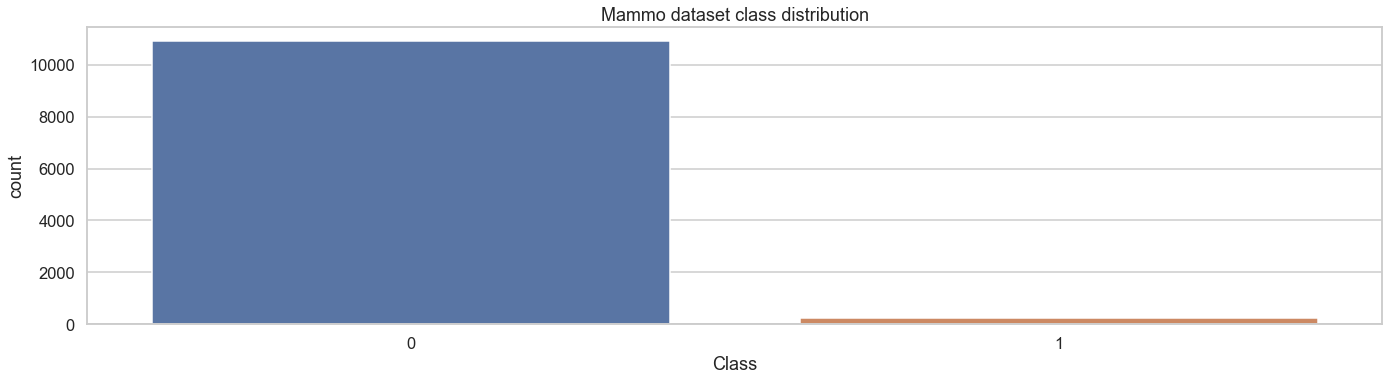

In [2]:
''' Prepare the Environment '''

#  load dataset
dataset = 'Mammo'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset(dataset)
estimator, base_estimator = 'DT', DecisionTreeClassifier(max_depth=None)
args = parser.parse_args()
n_estimators = args.max_estimators

# plot the class distribution
def plot_class_distribution(ax, labels, title):
    sns.countplot(data=pd.DataFrame(labels, columns=['Class']), x='Class', ax=ax)
    ax.set(title=title)
   
sns.set(style='whitegrid')
sns.set_context('talk', font_scale=1)
fig, ax = plt.subplots(figsize=(20, 6))
plot_class_distribution( 
    ax = ax, 
    labels = np.concatenate([y_train, y_valid, y_test]),
    title = f'{dataset} dataset class distribution')
plt.tight_layout(pad=1.8)
plt.show()

In [3]:
''' Meta-training '''

# initialize MESA
print ('Dataset: {}'.format(dataset))
mesa = Mesa(
    args=args, 
    base_estimator=base_estimator, 
    n_estimators=args.max_estimators)

# start meta-training
print ('Start meta-training of MESA ... ...')
start_time = time.clock()
mesa.meta_fit(X_train, y_train, X_valid, y_valid, X_test, y_test)
end_time = time.clock()
print ('Meta-training time: {:.3f} s'.format(end_time - start_time))

Dataset: Mammo
Start meta-training of MESA ... ...
Epi.10   updates 0    |last-25-mean-aucprc| train 0.901 | valid 0.499 | test 0.533 | by rand
Epi.20   updates 0    |last-25-mean-aucprc| train 0.865 | valid 0.488 | test 0.514 | by rand
Epi.30   updates 0    |last-25-mean-aucprc| train 0.853 | valid 0.477 | test 0.514 | by rand
Epi.40   updates 0    |last-25-mean-aucprc| train 0.898 | valid 0.499 | test 0.546 | by rand
Epi.50   updates 0    |last-25-mean-aucprc| train 0.921 | valid 0.511 | test 0.564 | by rand
Epi.60   updates 40   |last-25-mean-aucprc| train 0.918 | valid 0.510 | test 0.559 | by mesa
Epi.70   updates 130  |last-25-mean-aucprc| train 0.938 | valid 0.540 | test 0.592 | by mesa
Epi.80   updates 220  |last-25-mean-aucprc| train 0.967 | valid 0.581 | test 0.645 | by mesa
Epi.90   updates 310  |last-25-mean-aucprc| train 0.976 | valid 0.597 | test 0.650 | by mesa
Epi.100  updates 400  |last-25-mean-aucprc| train 0.976 | valid 0.595 | test 0.651 | by mesa
Epi.110  updates 49

# Visualize the meta-training process

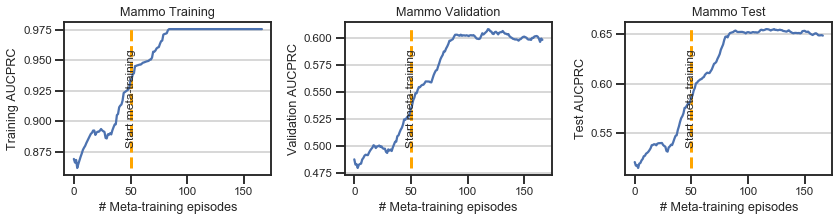

In [4]:
def slide_mean(data, window_half):
    result = []
    for i in range(len(data)):
        lower_bound = max(i-window_half, 0)
        upper_bound = min(i+window_half+1, len(data)-1)
        result.append(np.mean(data[lower_bound:upper_bound]))
    return result

slide_window_half = 25
df_scores = pd.DataFrame(mesa.scores, columns=['Training', 'Validation', 'Test'])

sns.set(style='ticks')
sns.set_context('talk', font_scale=0.7)
fig = plt.figure(figsize=(12, 3.5))
for i in range(df_scores.shape[1]):
    ax = plt.subplot(1, 3, i+1)
    column = df_scores.columns[i]
    view = pd.Series(slide_mean(df_scores[column], slide_window_half))
    sns.lineplot(data=view, ax=ax)
    start_steps = args.start_steps / args.max_estimators
    ax.vlines(start_steps, view.min(), view.max(), color="orange", linestyles='dashed', linewidth=3)
    ax.text(start_steps, 
            (view.min() + view.max()) / 2, 
            'Start meta-training', 
            rotation=90, ha='center', va='center', fontsize=12)
    ax.set(title=f'{dataset} {column}', 
           xlabel='# Meta-training episodes', 
           ylabel=f'{column} AUCPRC')    
    ax.grid(axis='y')

# fig.suptitle(f'Meta-training on {dataset} dataset')
plt.tight_layout(pad=1.8)
plt.show()

# Comparison with other resampling baselines

In [5]:
import numpy as np
from collections import Counter
from sklearn.model_selection import StratifiedKFold

from baselines.canonical_resampling import Resample_classifier

def evaluate(clf, X_train, y_train, X_valid, y_valid, X_test, y_test, rater):
    score_train = rater.score(y_train, clf.predict_proba(X_train)[:,1])
    score_valid = rater.score(y_valid, clf.predict_proba(X_valid)[:,1])
    score_test = rater.score(y_test, clf.predict_proba(X_test)[:,1])
    return [score_train, score_valid, score_test]

def stratifiedKFoldTest(clf, clf_name, X, y, X_valid, y_valid, rater,
                        n_splits=4, repeat=1, random_state=None):
    scores_list, time_list = [], []
    for i_repeat in range(repeat):
        skf = StratifiedKFold(n_splits=n_splits, random_state=random_state)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            start_time = time.clock()
            if clf_name[:4] == 'MESA':
                clf.fit(X_train, y_train, X_valid, y_valid, verbose=False)
            else:
                clf.fit(X_train, y_train)
            end_time = time.clock()
            time_list.append(end_time - start_time)
            scores = evaluate(clf, X_train, y_train, X_valid, y_valid, X_test, y_test, rater)
            scores_list.append(scores)
    return scores_list, time_list

cv_params = {
    'X': np.concatenate([X_train, X_test]),
    'y': np.concatenate([y_train, y_test]),
    'X_valid': X_valid,
    'y_valid': y_valid,
    'rater': Rater('aucprc'),
    'n_splits': 4,
    'repeat': 10,
}
    
resample_names = ['ORG', 'RUS', 'NM', 'NCR', 'ENN', 
    'Tomek', 'ALLKNN', 'OSS',  'ROS', 'SMOTE', 'ADASYN', 
    'BorderSMOTE', 'SMOTEENN', 'SMOTETomek']
resample_clf_list = [Resample_classifier(resample_by=method) for method in resample_names]

def copyMesa(mesa, n_estimators=None):
    mesa_copy = deepcopy(mesa)
    if n_estimators is not None:
        mesa_copy.n_estimators = n_estimators
    return mesa_copy

ensemble_size_list = [20, 10, 5]
clf_names = [f'MESA (k={size})' for size in ensemble_size_list] + resample_names
clf_list = [copyMesa(mesa, size) for size in ensemble_size_list] + resample_clf_list

df_results_list = []
for (clf, clf_name) in zip(clf_list, clf_names):
    scores_list, time_list = stratifiedKFoldTest(clf, clf_name, **cv_params)
    df_results = pd.DataFrame(scores_list, columns=['train', 'valid', 'test'])
    df_results['time'] = time_list
    df_results['method'] = clf_name
    df_results_list.append(df_results)
    info = '{:<12s} |'.format(clf_name)
    for column in ['train', 'valid', 'test']:
        info += ' {} {:.3f}-{:.3f} |'.format(
            column, df_results.mean()[column], df_results.std()[column])
    info += ' {}-fold CV ({} runs) | ave run time: {:.2f}s'.format(
        cv_params['n_splits'], cv_params['repeat'], np.mean(time_list))
    print (info)

MESA (k=20)  | train 0.972-0.003 | valid 0.683-0.034 | test 0.720-0.032 | 4-fold CV (10 runs) | ave run time: 0.17s
MESA (k=10)  | train 0.972-0.003 | valid 0.628-0.049 | test 0.662-0.043 | 4-fold CV (10 runs) | ave run time: 0.08s
MESA (k=5)   | train 0.918-0.048 | valid 0.469-0.048 | test 0.520-0.065 | 4-fold CV (10 runs) | ave run time: 0.04s
ORG          | train 0.973-0.003 | valid 0.292-0.033 | test 0.369-0.029 | 4-fold CV (10 runs) | ave run time: 0.01s
RUS          | train 0.151-0.020 | valid 0.115-0.016 | test 0.120-0.018 | 4-fold CV (10 runs) | ave run time: 0.00s
NM           | train 0.032-0.000 | valid 0.032-0.000 | test 0.032-0.001 | 4-fold CV (10 runs) | ave run time: 0.01s
NCR          | train 0.787-0.018 | valid 0.347-0.030 | test 0.358-0.048 | 4-fold CV (10 runs) | ave run time: 0.23s
ENN          | train 0.774-0.014 | valid 0.340-0.026 | test 0.370-0.050 | 4-fold CV (10 runs) | ave run time: 0.10s
Tomek        | train 0.928-0.014 | valid 0.318-0.032 | test 0.376-0.043 

In [6]:
pd.concat(df_results_list)

,train,valid,test,time,method
0,0.975476,0.669947,0.719724,0.167185,MESA (k=20)
1,0.969369,0.713182,0.748105,0.166814,MESA (k=20)
2,0.969269,0.636575,0.704720,0.195821,MESA (k=20)
3,0.975559,0.676892,0.668015,0.165471,MESA (k=20)
4,0.975497,0.704002,0.748813,0.184143,MESA (k=20)
...,...,...,...,...,...
35,0.957331,0.256955,0.283832,0.183794,SMOTETomek
36,0.951260,0.287299,0.251354,0.181292,SMOTETomek
37,0.970261,0.267259,0.387241,0.195728,SMOTETomek
38,0.957626,0.284939,0.249625,0.185287,SMOTETomek


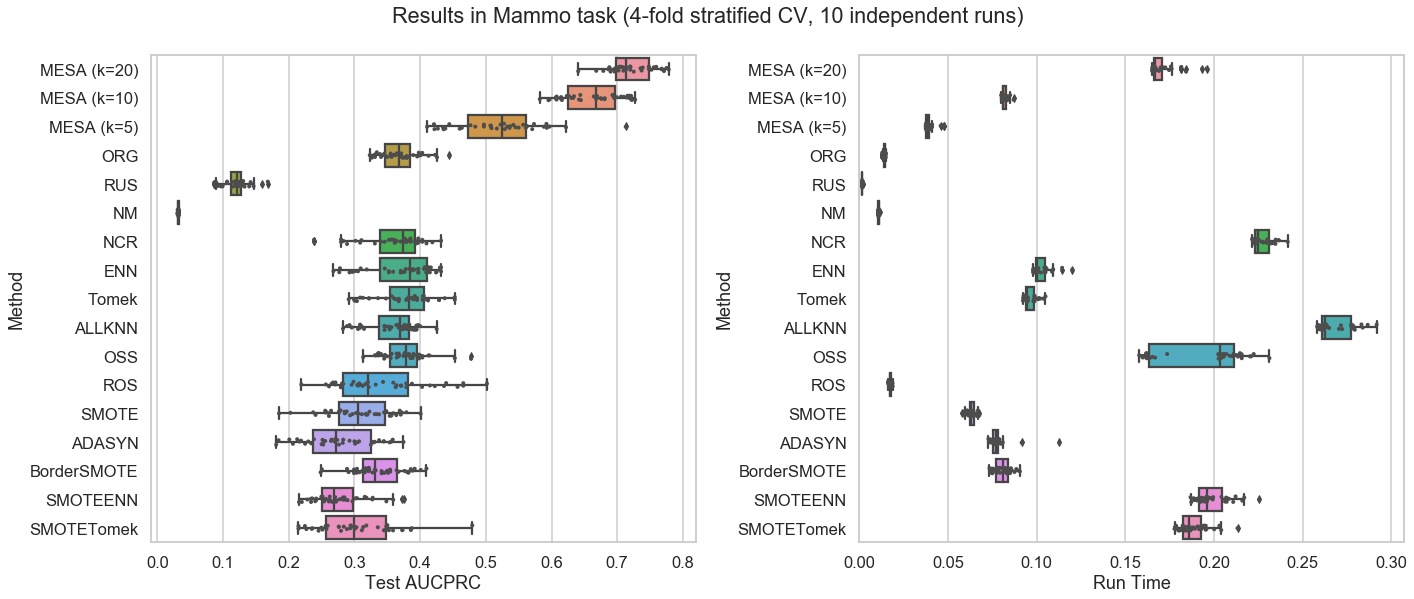

In [7]:
# visualize the performance with error bar
df_results_all = pd.concat(df_results_list)
order_performance = df_results_all.groupby('method').mean()['test'].sort_values(ascending=False).index.tolist()
order_runtime = df_results_all.groupby('method').mean()['time'].sort_values(ascending=True).index.tolist()

order_performance = order_runtime = clf_names

# fig = plt.figure(figsize=(20, 8))
sns.set(style='whitegrid')
sns.set_context('talk', font_scale=1)
# ax = sns.barplot(x='test', y='method', data=df_results_all, ci="sd", capsize=.2, order=order)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.stripplot(x='test', y='method', data=df_results_all, order=order_performance, size=4, color=".3", ax=ax1)
sns.boxplot(x='test', y='method', data=df_results_all, order=order_performance, ax=ax1)
ax1.set(xlabel='Test AUCPRC', ylabel='Method')
sns.stripplot(x='time', y='method', data=df_results_all, order=order_runtime, size=4, color=".3", ax=ax2)
sns.boxplot(x='time', y='method', data=df_results_all, order=order_runtime, ax=ax2)
ax2.set(xlabel='Run Time', ylabel='Method')

fig.suptitle('Results in {} task ({}-fold stratified CV, {} independent runs)'.format(dataset, cv_params['n_splits'], cv_params['repeat']), y=1.05)
plt.xlim(0,)
plt.tight_layout()
plt.show()